# Initial Imports & Setup

In [5]:
#!/usr/bin/env python3

# Data Science Modules
import numpy as np
import pandas as pd
import altair as alt
from selenium import webdriver

# Python Modules
import glob as glob
import os
import shutil
import datetime as datetime
from multiprocessing import Pool

#%load_ext blackcellmagic
%load_ext line_profiler

# Lookup Data

* **./files/names.csv**: CSV File with Provider/Clinic Names, etc. Names is used to determine active providers/clinics. (So if there's no name, it wont get evaluated later -- say, for example, after Everson Closes.)
* **./files/metrics.csv**: CSV File with Metrics information (Display Name, Category, Target, etc.)

In [6]:
# Read Lookup files into dataframes for mapping
names = pd.read_csv("./files/names.csv", index_col="MeridiosName")
metrics = pd.read_csv(
    "./files/metrics.csv", index_col="MeridiosMetric", dtype={"MeridiosMetric": object}
)

# Import Data from /data folder.

This makes a dataframe in a 'Tidy Data' format.

* **./data/(Zero-Padded Date at beginning of CSVs from Meridos).csv**: Files from Automatic weekly report from Meridios

In [7]:
# The base dataframe, df, get's transformed into different data subsets.
df = pd.DataFrame()

# Read in all the data files and append to dataframe
files = glob.glob("./data/*.csv")
for file in files:
    filedf = pd.read_csv(file, usecols=["NAME", "Metricname", "SeenNum", "SeenDenom"])
    # Prettier Names but we'll drop these eventually.
    filedf = filedf.rename(
        columns={
            "NAME": "MeridiosName",
            "Metricname": "MeridiosMetric",
            "SeenNum": "Numerator",
            "SeenDenom": "Denominator",
        }
    )

    # Add Lookup Columns.
    filedf["Name"] = filedf.MeridiosName.map(names.Name)
    filedf["Type"] = filedf.MeridiosName.map(names.Type)
    filedf["Clinic"] = filedf.MeridiosName.map(names.Clinic)
    filedf["Metric"] = filedf.MeridiosMetric.map(metrics.Metric)

    # Who are we kidding with precision? Round to Basis points
    # Not actually percentage (but rather than * 100 leaving for formatting
    # in visualization.)
    filedf["Percentage"] = round(filedf["Numerator"] / filedf["Denominator"], 4)

    # Zero Padded Dates with Dots. Like: "03.15.2018" We're using the filename
    # as the source of the date column because Meridios exports haven't always
    # had the date-time data correct.
    filename_parts = file[7:-4].split(" ")
    if len(str(filename_parts[0])) is 10:
        filedf["Date"] = datetime.datetime.strptime(filename_parts[0], "%m.%d.%Y")

        # Now delete the 'raw' columns from import so dataframe is smaller.
        filedf.drop(
            ["MeridiosName", "MeridiosMetric", "Numerator", "Denominator"],
            axis=1,
            inplace=True,
        )
        df = df.append(filedf)
    else:
        # We're only appending data that had Zero Padded Date at
        # beginning of filename.
        raise ValueError("CSV Filename should have Zero Padded Date.")


# Dataframe Review

The dataframe is the dataset for all the various graphs. We can inspect it various ways, if needed. (Used for development, not really validation.)

In [4]:
# df.dtypes
# df.info()
# df.describe()
# df.columns
# df.Metric.unique()
# df.head()
# metrics.head()

## Validations:

* Do new CSV files include new MeridiosName, New Metric items? (Has the underlying report changed? Such as when edited provider name.)
* Should we keep a list of already imported data and do some message to clarify after new data is available?
* Percentages under 0% and over 100% are report errors

Currently no validations. But probably should automate checks that new data from report is accurate. 

# Make Provider Graphs

In [16]:
def make_individual_metric_chart(metric, name):
    """
    Makes a chart for a single metric and a single provider.
    
    Assumes: dataframe 'df' that has all the data from CSVs
    Assumes: dataframes 'names' and 'metrics' for lookups
    """

    providerdf = df[
        (df["Metric"] == metric) & (df["Type"] == "Individual") & (df["Name"] == name)
    ]

    # Lookup clinic from the provider name in the names dataframe.
    # Make a comparison dataframe.
    clinic_name = names[names.Name == name].iloc[0].Clinic
    clinicdf = df[(df["Metric"] == metric) & (df["Name"] == clinic_name)]

    # Lookup the metric target -- not all metrics have a target.
    metric_target = metrics[metrics.Metric == metric].iloc[0].Target

    # If there's a target value, we'll make a rule on graph.
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    # Make a Current dataframe to use for Strip Chart.
    current_date = max(providerdf["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Individual")
        & (df["Date"] == current_date)
    ]

    # Altair Graphs to combine.
    provider_progress_line = (
        alt.Chart(providerdf)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.Color("Name:N", legend=None),
        )
        .properties(width=200, height=200)
    )

    # 1f77b4 -- blue, #ff7f0e -- orange. Currently hardcoded but eventually
    # will look up a clinic color. Also will be used in the HTML generation.

    clinic_progress_line = (
        alt.Chart(clinicdf)
        .mark_line(strokeWidth=2)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#ff7f0e"),
        )
    )

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4, 2])
            .encode(
                y="TargetValue:Q", color=alt.value("green"), opacity=alt.value("0.5")
            )
        )

    fcn_current_strip_chart = (
        alt.Chart(current_metric)
        .mark_tick(color="#eee")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title="", labels=False),
                scale=alt.Scale(domain=(0, 1)),
            )
        )
        .properties(height=200)
    )

    provider_highlight_strip = (
        alt.Chart(current_metric)
        .mark_tick()
        .encode(alt.Y("Percentage:Q"), opacity=alt.value("1.0"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=name))
    )

    provider_percent = (
        provider_highlight_strip.mark_text(
            align="left", baseline="middle", dx=15, size=20
        )
        .encode(text=alt.Text("Percentage:Q", format=".2%"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=name))
    )

    if metric_target:
        chart = provider_progress_line + clinic_progress_line + metric_target_rule | (
            fcn_current_strip_chart + provider_highlight_strip + provider_percent
        )
        return chart
    else:
        chart = provider_progress_line + clinic_progress_line | (
            fcn_current_strip_chart + provider_highlight_strip + provider_percent
        )
        return chart


# Make Clinic Graphs


In [26]:
def make_clinic_metric_chart(metric, clinic_name):
    """
    Makes a chart for a single metric and a clinic.
    
    Assumes: dataframe 'df' that has all the data from CSVs
    Assumes: dataframes 'names' and 'metrics' for lookups
    """

    providerdf = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Clinic")
        & (df["Name"] == clinic_name)
    ]

    metric_target = metrics[metrics.Metric == metric].iloc[0].Target

    # If there's a target value, we'll make a rule on graph.
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    current_date = max(providerdf["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Clinic")
        & (df["Date"] == current_date)
    ]

    # Altair Graphs to combine.
    clinic_progress_line = (
        alt.Chart(providerdf)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#ff7f0e"),
        )
        .properties(width=200, height=200)
    )

    # 1f77b4 -- blue, #ff7f0e -- orange

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4, 2])
            .encode(
                y="TargetValue:Q", color=alt.value("green"), opacity=alt.value("0.5")
            )
        )

    clinic_providers = sorted(
        set(singleproviders[singleproviders.Clinic == clinic_name].Name)
    )
    #current_date = max(df["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == current_date)
        & (df["Name"].isin(clinic_providers))
    ]

    start_date = min(providerdf["Date"])
    start_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == start_date)
        & (df["Name"].isin(clinic_providers))
    ]
    start_and_current = pd.concat([start_metric, current_metric])

    ranged_dot = (
        alt.Chart(start_and_current)
        .mark_line(color="#aec7e8")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            alt.X("Name:N", axis=alt.Axis(title="")),
            detail="Name:N",
        )
        .properties(height=200)
    )

    ranged_dot += (
        alt.Chart(current_metric)
        .mark_point(size=100, opacity=1, filled=True, color="#1f77b4")
        .encode(y="Percentage:Q", x="Name:N")
    )

    ranged_dot_rule = (
        alt.Chart(metricdf)
        .mark_rule(strokeWidth=1, strokeDash=[4, 2])
        .encode(y="TargetValue:Q", color=alt.value("green"), opacity=alt.value("0.5"))
    )

    if metric_target:
        chart = (
            clinic_progress_line + metric_target_rule
        ) | ranged_dot + ranged_dot_rule
        return chart
    else:
        chart = (clinic_progress_line) | ranged_dot
        return chart


# Prepping for the website generation

In [10]:
# Need to just do active individuals, main metrics
singleproviders = names[(names["Type"] == "Individual")]

clinics = sorted(set(df[(df["Type"] == "Clinic")].Name.unique()))

main_metrics = [
    "AAA",
    "Chlamydia",
    "Colorectal Screen",
    "DM with Statin",
    "DM with ACE or ARB",
    "DM Eye Exam",
    "DM Foot Exam",
    "Mammogram",
    "DM Nephropathy",
    "Pap Smears",
    "DM Pneumovax",
    "Over age 65 Pneumovax",
    "Smoker Pneumovax",
    "TD and TDAP",
]

dt = max(df["Date"])
current_date = dt.strftime("%m/%d/%Y")


def savefolder(name):
    foldername = str(name).replace(" ", "_")
    if not os.path.exists("./docs/" + foldername):
        os.makedirs("./docs/" + foldername)
    return "./docs/" + foldername + "/"


def create_individual_metrics(name):
    for metric in main_metrics:
        chart = make_individual_metric_chart(metric, name)
        chart.save(
            savefolder(name) + str(metric).replace(" ", "_") + ".png", scale_factor=2
        )


def create_clinic_metrics(clinic_name):
    for metric in main_metrics:
        chart = make_clinic_metric_chart(metric, clinic_name)
        chart.save(
            savefolder(clinic_name) + str(metric).replace(" ", "_") + ".png",
            scale_factor=2,
        )


# Generate Charts

Using multiprocessing. 

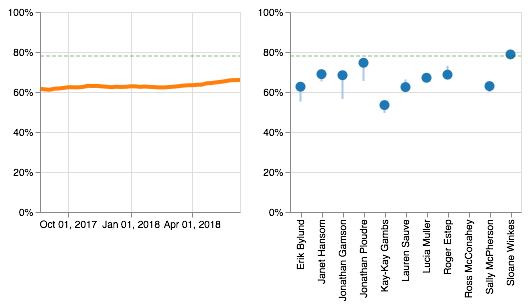

In [32]:
chart = make_clinic_metric_chart("Mammogram", "NCFP")
chart

In [21]:
pool = Pool()
pool.map(create_individual_metrics, singleproviders.Name.unique())
pool.close()
pool.join()

pool2 = Pool()
pool2.map(create_clinic_metrics, clinics)
pool2.close()
pool2.join()


Process ForkPoolWorker-2:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/jonathan/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonathan/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonathan/miniconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/jonathan/miniconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-10-3ed7988dcc23>", line 36, in create_individual_metrics
    chart = make_individual_metric_chart(metric, name)
  File "<ipython-input-16-64d28d9736ef>", line 16, in make_individual_metric_chart
    clinicdf = df[(df["Metric"] == metric) & (df["Name"] == clinic_name)]
  File "/Users/jonathan/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py", line 1253, in wrapper
    res = na_op(values, other)
  File "/Users/jonat

# Generate Provider HTMLs

In [ ]:
# Provider HTML Files
for name in sorted(set(singleproviders.Name.unique())):
    provider_picture = "./files/pictures/" + str(name).replace(" ", "_") + ".JPG"
    if os.path.isfile(provider_picture):
        if not os.path.exists("./docs/pictures/"):
            os.makedirs("./docs/pictures/")
        shutil.copyfile(
            provider_picture, "./docs/pictures/" + str(name).replace(" ", "_") + ".JPG"
        )
        provider_icon = (
            '<img src="'
            + "../pictures/"
            + str(name).replace(" ", "_")
            + ".JPG"
            + '" width="64" height="64">&nbsp;'
        )

    provider_dropdown = (
        '<div class="uk-inline"><div class="uk-text-lead uk-text-bold uk-text-middle" style="color:#1f77b4">'
        + provider_icon
        + name
        + '<span uk-icon="icon: triangle-down"></span>'
        + '</div><div uk-dropdown><ul class="uk-nav uk-dropdown-nav">'
    )

    clinic_name = names[names.Name == name].iloc[0].Clinic

    for sameclinicprovider in sorted(
        set(singleproviders[singleproviders.Clinic == clinic_name].Name)
    ):
        if name == sameclinicprovider:
            provider_dropdown += (
                '<li class="uk-active">'
                + sameclinicprovider
                + '<span uk-icon="icon: check"></span></li>\n'
            )
        else:
            provider_dropdown += (
                '<li><a href="../'
                + str(sameclinicprovider).replace(" ", "_")
                + '/">'
                + sameclinicprovider
                + "</a></li>\n"
            )

    # close provider_dropdown
    provider_dropdown += "</ul></div></div>"

    clinic_dropdown = (
        '<div class="uk-inline"><div class="uk-text-lead uk-text-middle" style="color:#ff7f0e">'
        + clinic_name
        + '<span uk-icon="icon: triangle-down"></span>'
        + '</div><div uk-dropdown><ul class="uk-nav uk-dropdown-nav">'
    )

    for clinic in clinics:
        clinic_dropdown += (
            '<li><a href="../'
            + str(clinic).replace(" ", "_")
            + '/">'
            + clinic
            + "</a></li>\n"
        )

    clinic_dropdown += "</ul></div></div>"

    with open("./files/index.html", "r") as file:
        filedata = file.read()
    filedata = filedata.replace("{{{Provider}}}", provider_dropdown)
    filedata = filedata.replace("{{{Clinic}}}", clinic_dropdown)
    filedata = filedata.replace("{{{Current Date}}}", current_date)
    with open(savefolder(name) + "index.html", "w+") as file:
        file.write(filedata)


# Generate Clinic HTMLs

In [ ]:
# Clinic HTML Files
for clinic in clinics:
    provider_dropdown = (
        '<div class="uk-inline"><div class="uk-text-lead uk-text-middle" style="color:#1f77b4">'
        + "Providers"
        + '<span uk-icon="icon: triangle-down"></span>'
        + '</div><div uk-dropdown><ul class="uk-nav uk-dropdown-nav">'
    )

    clinic_name = clinic

    for sameclinicprovider in sorted(
        set(singleproviders[singleproviders.Clinic == clinic_name].Name)
    ):
        provider_dropdown += (
            '<li><a href="../'
            + str(sameclinicprovider).replace(" ", "_")
            + '/">'
            + sameclinicprovider
            + "</a></li>\n"
        )

    # close provider_dropdown
    provider_dropdown += "</ul></div></div>"

    clinic_dropdown = (
        '<div class="uk-inline"><div class="uk-text-lead uk-text-bold uk-text-middle" style="color:#ff7f0e">'
        + clinic_name
        + '<span uk-icon="icon: triangle-down"></span>'
        + '</div><div uk-dropdown><ul class="uk-nav uk-dropdown-nav">'
    )

    for clinic in clinics:
        if clinic == clinic_name:
            clinic_dropdown += (
                '<li class="uk-active">'
                + clinic
                + '<span uk-icon="icon: check"></span></li>\n'
            )
        else:
            clinic_dropdown += (
                '<li><a href="../'
                + str(clinic).replace(" ", "_")
                + '/">'
                + clinic
                + "</a></li>\n"
            )

    clinic_dropdown += "</ul></div></div>"

    with open("./files/index.html", "r") as file:
        filedata = file.read()
    filedata = filedata.replace("{{{Provider}}}", provider_dropdown)
    filedata = filedata.replace("{{{Clinic}}}", clinic_dropdown)
    filedata = filedata.replace("{{{Current Date}}}", current_date)
    with open(savefolder(clinic_name) + "index.html", "w+") as file:
        file.write(filedata)

# Generate Base HTML

In [ ]:
# Base HTML File
root_index_clinic = (
    '<div uk-filter="target: .js-filter"><ul class="uk-subnav uk-subnav-pill">\n'
)
for clinic in sorted(set(clinics)):
    root_index_clinic += (
        '<li uk-filter-control=".tag-'
        + clinic
        + '"><a href="#">'
        + clinic
        + "</a></li>\n"
    )
root_index_clinic += "</ul>"

provider_index_cards = (
    '<ul class="js-filter uk-grid-match uk-card-small uk-text-center" uk-grid>\n'
)



for name in sorted(set(singleproviders.Name.unique())):
    provider_icon = (
            '<img class="uk-align-center" src="'
            + "./pictures/"
            + str(name).replace(" ", "_")
            + ".JPG"
            + '" width="64" height="64">'
        )
    provider_index_cards += (
        '<li class="tag-'
        + names[names.Name == name].iloc[0].Clinic
        + '"><a class="uk-align-center" href="./'
        + str(name).replace(" ", "_")
        + '/"><div class="uk-card uk-width-medium uk-card-hover uk-card-default uk-card-body">'
        + provider_icon 
        + name
        + "</div></a></li>\n"
    )
provider_index_cards += "</ul>"

with open("./files/index-base.html", "r") as file:
    filedata = file.read()
filedata = filedata.replace("{{{Clinics}}}", root_index_clinic)
filedata = filedata.replace("{{{Provider-Index-Cards}}}", provider_index_cards)
filedata = filedata.replace("{{{Current Date}}}", current_date)
with open("docs/" + "index.html", "w+") as file:
    file.write(filedata)
